In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradients Parcelwise PLS

In [2]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships.

This script:
1. Loads gradient CSVs (one per gradient).
2. Filters to patient groups (diagnosis 2 = bipolar, 3 = schizophrenia).
3. Encodes categorical vars numerically (gender, diagnosis).
4. Z-scores individual cognitive tests before averaging into domains.
5. Inverts cognitive domain scores (higher = worse performance).
6. Regresses out age and gender from brain features (X).
7. Z-scores both X and Y before PLS.
8. Fits PLS and extracts saliences (x_weights_, y_weights_), scores, and behavior–LV correlations.
9. Stores results in a dictionary and prints summaries.

"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog_updated.csv', './g2_aligned_cog_updated.csv', './g3_aligned_cog_updated.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from brain features
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------

def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """
    Regress out confounding variables (e.g., age, gender) from each column of X.
    X: n × p data matrix
    covariates: n × k matrix of confound variables
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)

        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y = patient_df[Y_cols].values

    # ------------------------
    # Remove any subjects with missing data in X or Y
    # ------------------------
    nan_rows_X = np.isnan(X).any(axis=1)
    nan_rows_Y = np.isnan(Y).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_valid = X[valid_mask]
    Y_valid = Y[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out age and gender from X (per voxel)
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid = regress_out(X_valid, covars)

    # ------------------------
    # Standardize (z-score) both X and Y (column-wise)
    # ------------------------
    # Standardize
    X_std = StandardScaler().fit_transform(X_valid)
    Y_std = StandardScaler().fit_transform(Y_valid)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std, Y_std)

    # Saliences (weights) for X and Y
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores (how much each subject expresses the LV pattern)
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate each behavioral variable with the LV behavioral score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std': X_std,   # standardized brain data
        'Y_std': Y_std    # standardized behavioral data
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (higher = worse severity):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results stored in `results` dict.")


--- Processing G1 ---
G1 behavioral correlations (higher = worse severity):
  diagnosis                :  0.775
  SAPSDisorganization      : -0.450
  Amotivation              : -0.506
  DimEx                    : -0.518
  SAPSPositiveSymptoms     : -0.705
  hamilton_21              : -0.162
  YMRS                     : -0.164
  Attention_WorkingMemory  : -0.567
  VerbalLearning_Memory    : -0.613
  Reasoning_ProblemSolving : -0.587
  Verbal_Comprehension     : -0.611

--- Processing G2 ---
G2 behavioral correlations (higher = worse severity):
  diagnosis                :  0.757
  SAPSDisorganization      : -0.427
  Amotivation              : -0.516
  DimEx                    : -0.529
  SAPSPositiveSymptoms     : -0.729
  hamilton_21              : -0.229
  YMRS                     : -0.168
  Attention_WorkingMemory  : -0.567
  VerbalLearning_Memory    : -0.612
  Reasoning_ProblemSolving : -0.565
  Verbal_Comprehension     : -0.595

--- Processing G3 ---
G3 behavioral correlations (hig

## Cortical projection of loadings

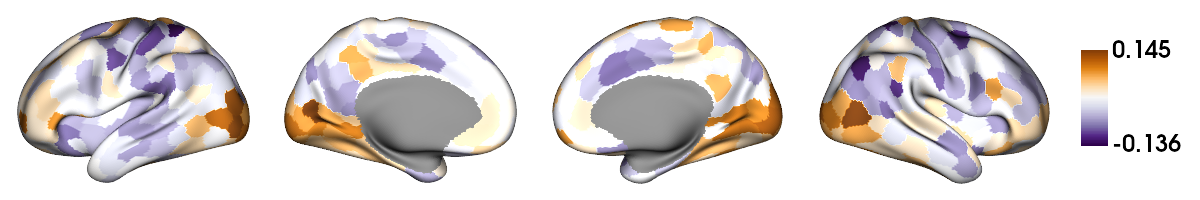

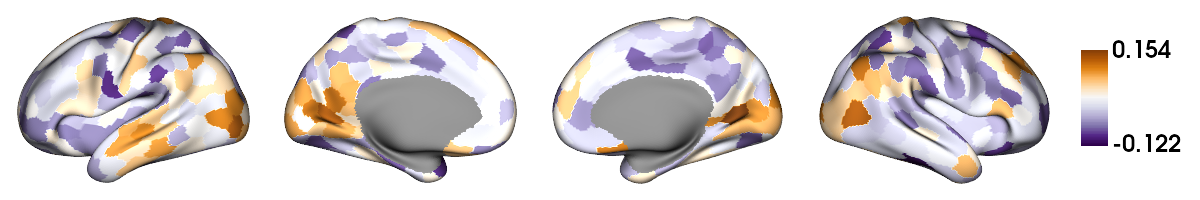

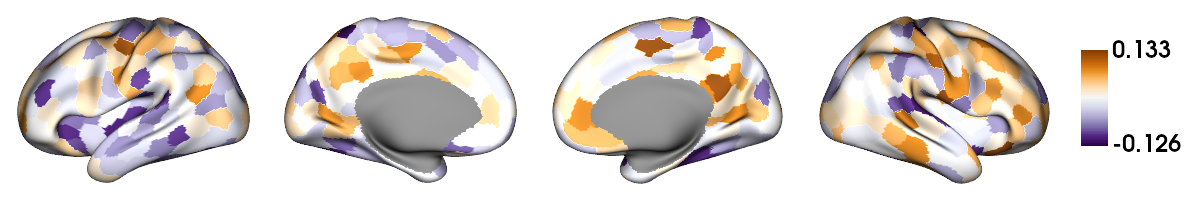

In [3]:
from IPython.display import Image, display
import numpy as np

# Loop through all gradients in the PLS results
for grad_name in results.keys():
    X_saliences = results[grad_name]['X_saliences']  # LV1 only

    # Create brain map with NaNs everywhere except labeled parcels
    brain_map = np.full_like(atlas, np.nan, dtype=float)
    for j in range(len(X_saliences)):
        brain_map[atlas == j + 1] = X_saliences[j]
    brain_map[atlas == 0] = np.nan

    # Save filename
    filename = f'./new_figures/{grad_name}_LC1_map_cortex.png'

    # Plot cortical surface (using your custom plotting function `fp.plot_surface`)
    fp.plot_surface(
        data=[brain_map],
        size=(1200, 200),
        cmap='PuOr_r',
        display=False,  # Save instead of showing interactively
        filename=filename
    )

    # Display the saved image
    display(Image(filename))


## Permutation testing

In [4]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized X and Y
    X = results[grad_name]['X_std']  # standardized X (brain data)
    Y = results[grad_name]['Y_std']  # standardized Y (behavioral data)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X, Y)
    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X
        X_perm = X[np.random.permutation(X.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y)
        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]
        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")



Permutation testing for G1...
G1 LV1 permutation p-value: 0.0829
Permutation testing for G2...
G2 LV1 permutation p-value: 0.7008
Permutation testing for G3...
G3 LV1 permutation p-value: 0.7696


## Bootstrap resampling

Bootstrap resampling for G1...


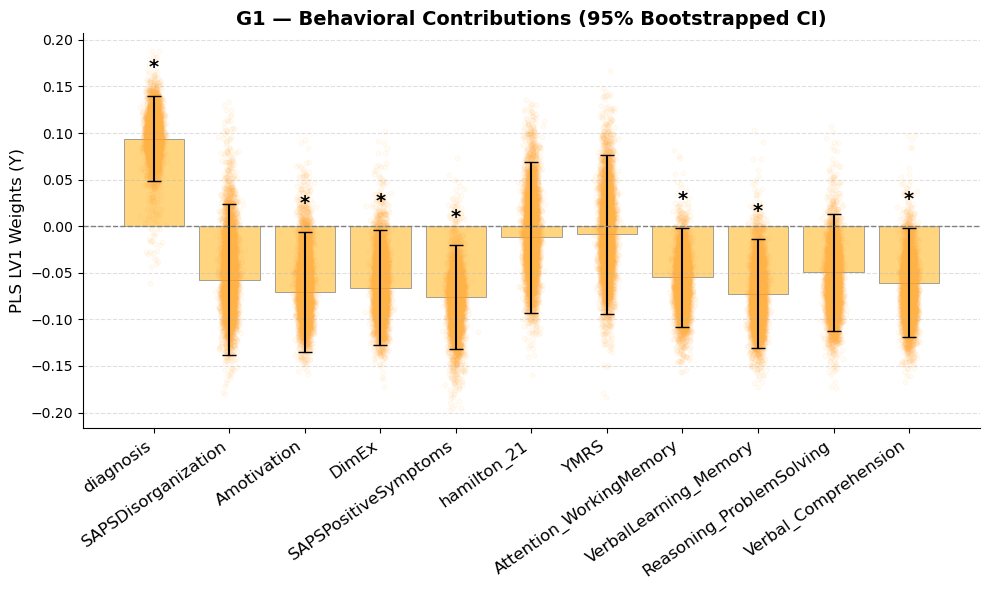

Bootstrap resampling for G2...


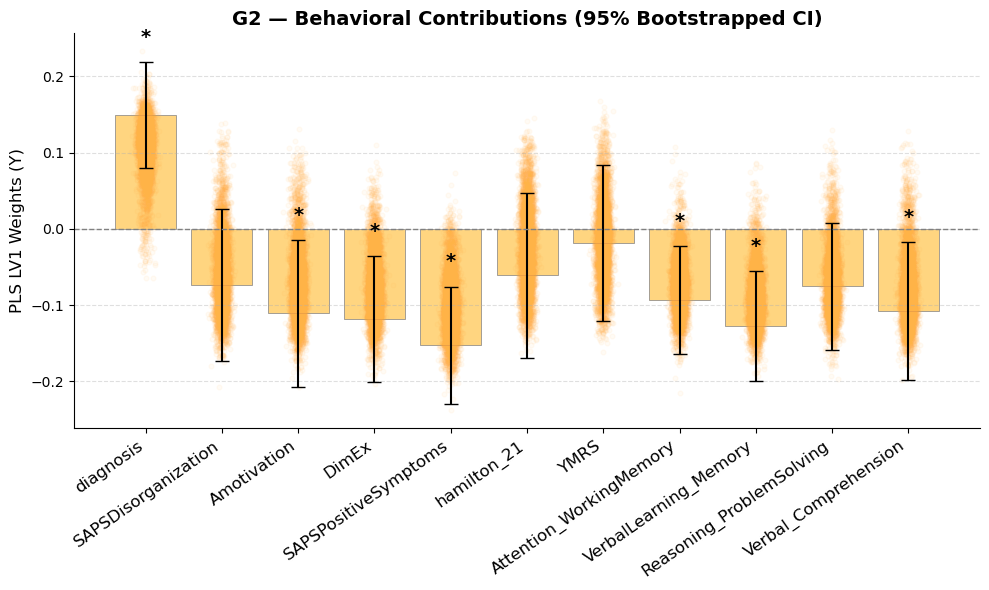

Bootstrap resampling for G3...


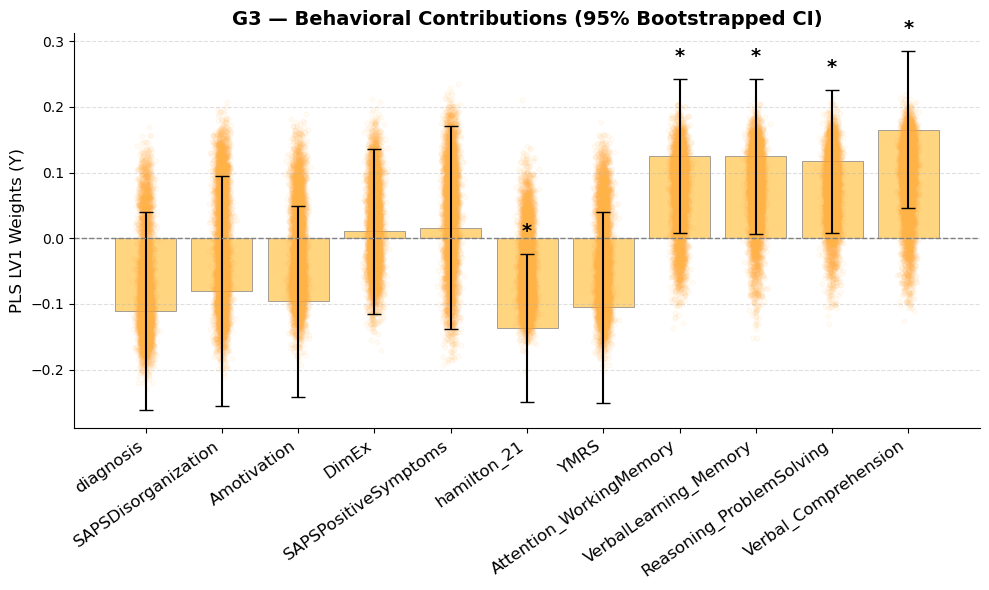

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Standardized X and Y
    X = res['X_std']
    Y = res['Y_std']
    n_subjects, n_voxels = X.shape
    n_behav = Y.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X, Y)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X, Y, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------

        # Align bootstrap LV1 with original LV1
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    
    # Mean and 95% CI
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10,6))

    # Bars with error bars
    bars = ax.bar(np.arange(n_behav), y_mean,
                  width=0.8,
                  yerr=[y_mean - lower_ci, upper_ci - y_mean],
                  capsize=5, color=bar_color, edgecolor='gray', linewidth=0.5)

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)', fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## New variance explained

1. Matrix-Based Shared Variance

What it measures:

- Think of the entire X–Y relationship as a big table showing how every brain region covaries with every behavioral score.
- LV₁ gives a partial reconstruction of this table.
- Matrix-based shared variance tells you: “How much of the total pattern of brain–behavior covariance is explained by LV₁?”

Key point:

- It considers all features in X and Y.
- If LV₁ captures only part of the table, the fraction < 100%.

2. Latent-Score–Based Shared Variance

What it measures:

- Instead of looking at all features, it just looks at the summary numbers for each subject: the latent scores t (brain) and u (behavior).
- Then it checks how much these two numbers co-vary.

Analogy: Imagine each subject has a single “brain score” and a single “behavior score” from LV₁. How strongly do these two scores move together across subjects? Latent-score metric = fraction of total covariance energy captured by just this one pair of summary scores.

Key point:

- This is a simpler, lower-dimensional view.
- Usually, it’s ≤ the matrix-based metric, because we’re ignoring all the other details of X and Y.

Computing variance explained for gradients-based PLS across all gradients...

G1:
  LV1 explains 9.05% of X variance, 9.48% of Y variance, 57.92% of total X–Y cross-covariance energy, and t-u squared correlation = 32.80%

G2:
  LV1 explains 4.72% of X variance, 14.04% of Y variance, 49.28% of total X–Y cross-covariance energy, and t-u squared correlation = 48.72%

G3:
  LV1 explains 3.83% of X variance, 13.25% of Y variance, 37.18% of total X–Y cross-covariance energy, and t-u squared correlation = 61.30%



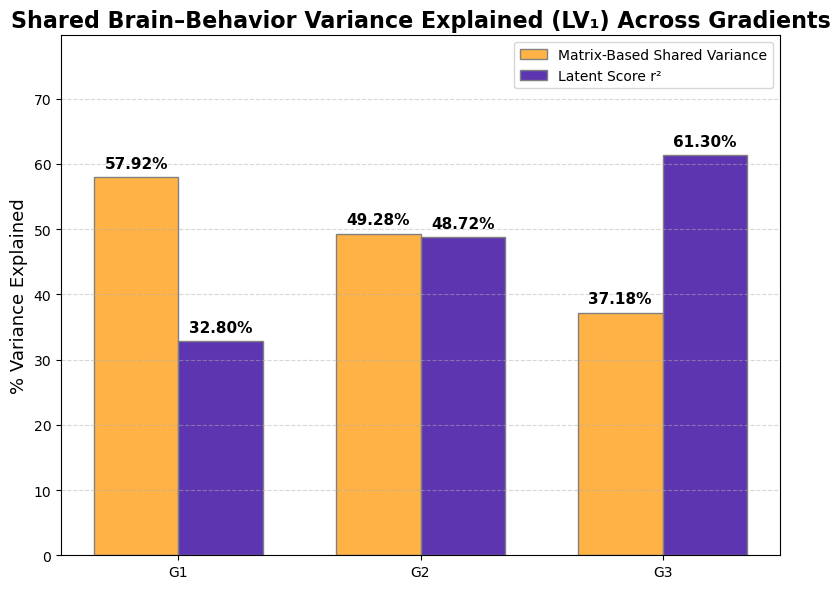

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

os.makedirs("new_figures", exist_ok=True)

var_explained_dict = {}

print("Computing variance explained for gradients-based PLS across all gradients...\n")

for grad_name, res in results.items():

    X = res['X_std']
    Y = res['Y_std']
    n_samples = X.shape[0]

    pls = PLSRegression(n_components=1)
    pls.fit(X, Y)

    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    var_X_expl = np.sum(X_pred**2) / np.sum(X**2)
    var_Y_expl = np.sum(Y_pred**2) / np.sum(Y**2)

    # Shared variance (matrix-based)
    C_full = (X.T @ Y) / (n_samples - 1)
    C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
    total_cross_energy = np.sum(C_full**2)
    explained_cross_energy = np.sum(C_pred**2)
    shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

    # Latent scores squared correlation
    t = pls.x_scores_[:, 0]
    u = pls.y_scores_[:, 0]
    r2_latent = np.corrcoef(t, u)[0, 1]**2

    # Store results
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var_matrix'] = shared_var_matrix
    res['r2_latent'] = r2_latent

    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared_matrix%': shared_var_matrix * 100,
        'r2_latent%': r2_latent * 100
    }

    print(f"{grad_name}:")
    print(f"  LV1 explains {var_X_expl*100:.2f}% of X variance, "
          f"{var_Y_expl*100:.2f}% of Y variance, "
          f"{shared_var_matrix*100:.2f}% of total X–Y cross-covariance energy, "
          f"and t-u squared correlation = {r2_latent*100:.2f}%\n")

# --- Combined plot for all gradients ---
grad_names = list(var_explained_dict.keys())
matrix_vals = [v['Shared_matrix%'] for v in var_explained_dict.values()]
latent_vals = [v['r2_latent%'] for v in var_explained_dict.values()]

x = np.arange(len(grad_names))
width = 0.35  # width of the bars

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, matrix_vals, width, label='Matrix-Based Shared Variance', color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, latent_vals, width, label='Latent Score r²', color='#5E35B1', edgecolor='gray')

# Add value labels
for i in range(len(grad_names)):
    plt.text(x[i] - width/2, matrix_vals[i] + 1, f"{matrix_vals[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, latent_vals[i] + 1, f"{latent_vals[i]:.2f}%", ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, grad_names)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁) Across Gradients", fontsize=16, fontweight='bold')
plt.ylim(0, max(max(matrix_vals), max(latent_vals)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1.png", dpi=300)
plt.show()


# PLS gradients parcelwise, regression of age and gender from behavior

In [7]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships,
with age and gender regressed out from both brain (X) and behavioral (Y) variables.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog_updated.csv', './g2_aligned_cog_updated.csv', './g3_aligned_cog_updated.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include
other_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
              'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates to regress out from both X and Y
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------

def ensure_numeric_encoding(df, col):
    """Ensure categorical columns (e.g., gender) are numeric."""
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df


def regress_out(X, covariates):
    """
    Regress out confounding variables (e.g., age, gender) from each column of X.
    X: n × p data matrix
    covariates: n × k matrix of confound variables
    """
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid


# ------------------------
# Main analysis
# ------------------------
results = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} ---")

    # Load gradient file
    df = pd.read_csv(grad_file)

    # Keep only patients with diagnosis 2 (bipolar) and 3 (schizophrenia)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    # Ensure categorical vars are numeric
    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    # Define parcel columns (assuming node_1 ... node_400)
    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), \
        f"Missing parcel columns in {grad_name}"

    X_brain = patient_df[parcel_cols].values

    # ------------------------
    # Create grouped cognitive domains
    # ------------------------
    for group_name, var_list in group_definitions.items():
        # Z-score each cognitive variable before averaging
        zscored = patient_df[var_list].apply(lambda x: (x - x.mean()) / x.std(), axis=0)
        domain_score = zscored.mean(axis=1)

        # Invert so higher = worse
        patient_df[group_name] = -domain_score

    # Combine behavioral + clinical variables (Y)
    Y_cols = other_vars + list(group_definitions.keys())
    Y_behav = patient_df[Y_cols].values

    # ------------------------
    # Remove subjects with missing data
    # ------------------------
    nan_rows_X = np.isnan(X_brain).any(axis=1)
    nan_rows_Y = np.isnan(Y_behav).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_brain_valid = X_brain[valid_mask]
    Y_behav_valid = Y_behav[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out covariates from both X and Y
    # ------------------------
    covars = patient_df_valid[covariate_cols].values

    # Brain features residualized
    X_resid_brain = regress_out(X_brain_valid, covars)

    # Behavioral variables residualized
    Y_resid_behav = regress_out(Y_behav_valid, covars)

    # ------------------------
    # Standardize residualized data
    # ------------------------
    X_std_resid = StandardScaler().fit_transform(X_resid_brain)
    Y_std_resid = StandardScaler().fit_transform(Y_resid_behav)

    # ------------------------
    # Fit Partial Least Squares (PLS)
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std_resid, Y_std_resid)

    # Saliences (weights)
    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]

    # Subject scores
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    # Correlate behavioral variables with LV score
    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std_resid[:, i], Y_scores)
        behav_corrs[var] = corr

    # ------------------------
    # Save results
    # ------------------------
    results[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std_resid': X_std_resid,  # standardized + residualized brain data
        'Y_std_resid': Y_std_resid   # standardized + residualized behavioral data
    }

    # ------------------------
    # Print summary
    # ------------------------
    print(f"{grad_name} behavioral correlations (after regressing age/gender):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

# ------------------------
# End of pipeline
# ------------------------
print("\nAll gradients processed. Results stored in `results` dict.")



--- Processing G1 ---
G1 behavioral correlations (after regressing age/gender):
  diagnosis                :  0.756
  SAPSDisorganization      : -0.416
  Amotivation              : -0.584
  DimEx                    : -0.596
  SAPSPositiveSymptoms     : -0.745
  hamilton_21              : -0.326
  YMRS                     : -0.148
  Attention_WorkingMemory  : -0.497
  VerbalLearning_Memory    : -0.540
  Reasoning_ProblemSolving : -0.489
  Verbal_Comprehension     : -0.531

--- Processing G2 ---
G2 behavioral correlations (after regressing age/gender):
  diagnosis                :  0.720
  SAPSDisorganization      : -0.389
  Amotivation              : -0.591
  DimEx                    : -0.606
  SAPSPositiveSymptoms     : -0.750
  hamilton_21              : -0.398
  YMRS                     : -0.156
  Attention_WorkingMemory  : -0.502
  VerbalLearning_Memory    : -0.541
  Reasoning_ProblemSolving : -0.480
  Verbal_Comprehension     : -0.510

--- Processing G3 ---
G3 behavioral correlati

## Permutation testing

In [8]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized + residualized X and Y
    X_resid_std = results[grad_name]['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = results[grad_name]['Y_std_resid']  # behavioral data (residualized + standardized)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_resid_std, Y_resid_std)

    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X (breaks brain–behavior correspondence)
        X_perm = X_resid_std[np.random.permutation(X_resid_std.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y_resid_std)

        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]

        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")


Permutation testing for G1...
G1 LV1 permutation p-value: 0.1668
Permutation testing for G2...
G2 LV1 permutation p-value: 0.7736
Permutation testing for G3...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


G3 LV1 permutation p-value: 0.6868


## Bootstrap resampling

Bootstrap resampling for G1...


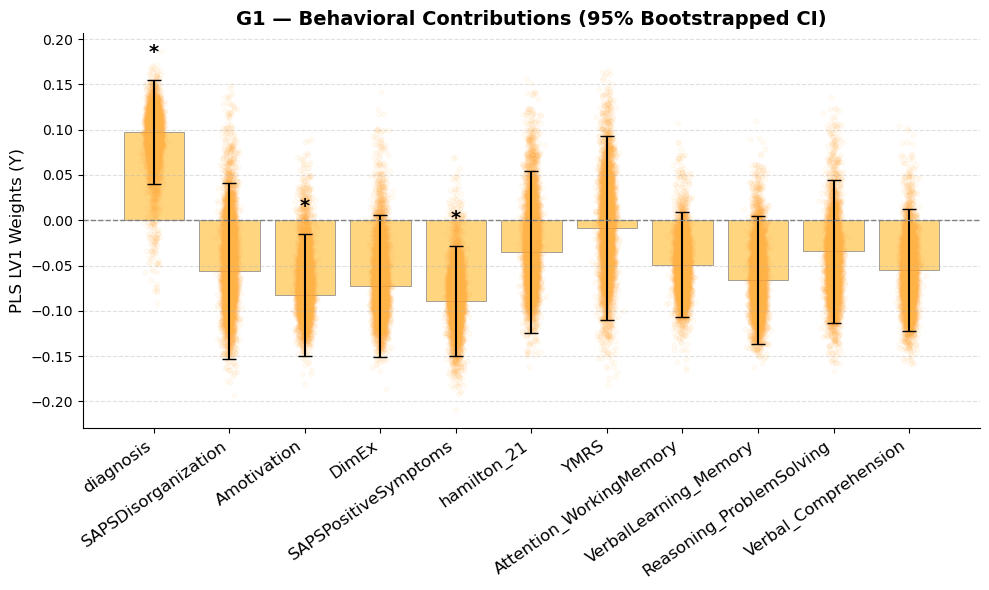

Bootstrap resampling for G2...


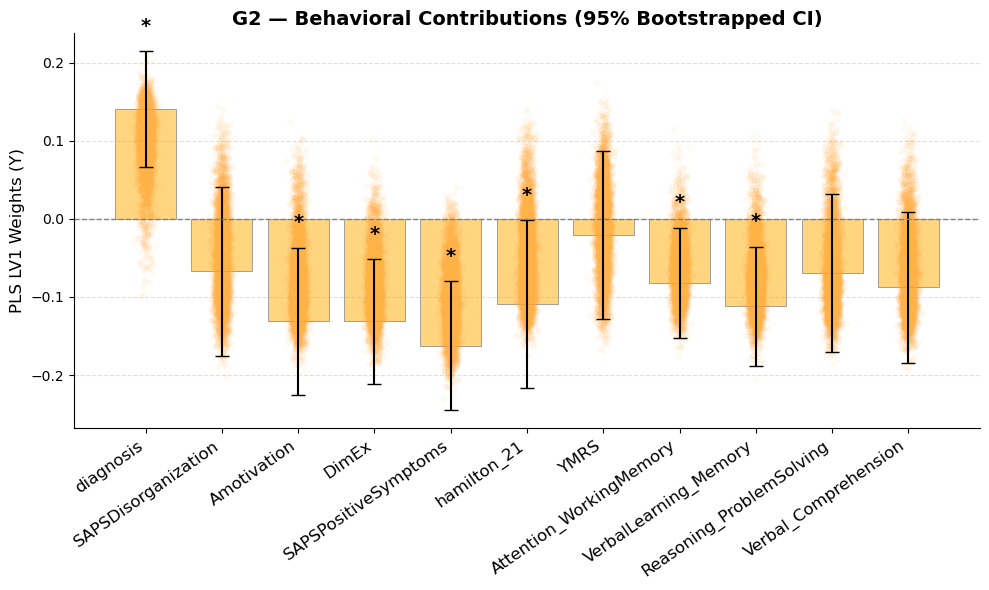

Bootstrap resampling for G3...


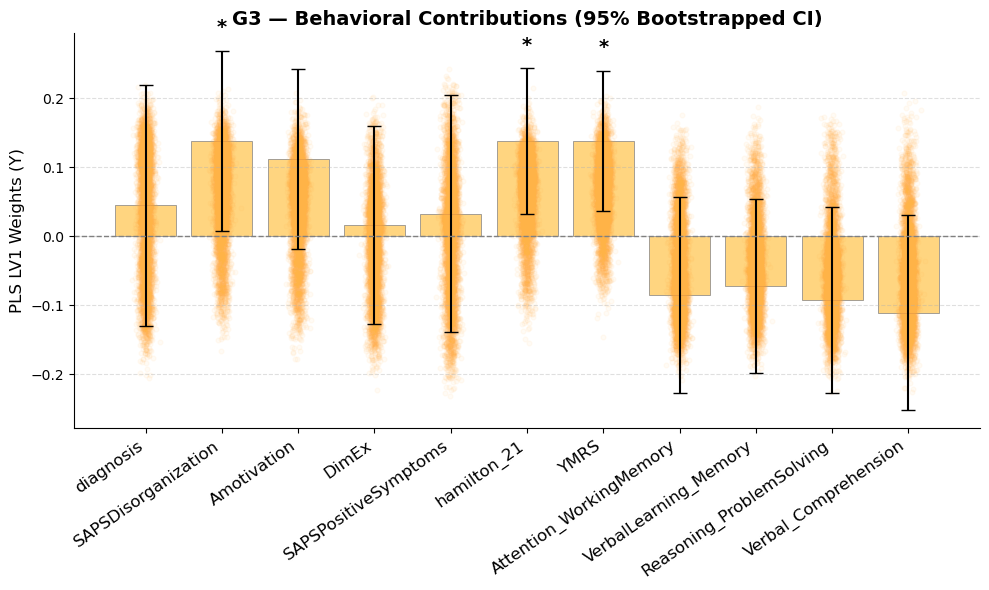

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Residualized + standardized X and Y
    X_resid_std = res['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = res['Y_std_resid']  # behavioral data (residualized + standardized)
    n_subjects, n_voxels = X_resid_std.shape
    n_behav = Y_resid_std.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X_resid_std, Y_resid_std)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X_resid_std, Y_resid_std, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars with error bars
    bars = ax.bar(
        np.arange(n_behav),
        y_mean,
        width=0.8,
        yerr=[y_mean - lower_ci, upper_ci - y_mean],
        capsize=5,
        color=bar_color,
        edgecolor='gray',
        linewidth=0.5
    )

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)',
                 fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## New variance explained

Computing variance explained for residualized (age/gender regressed) gradients-based PLS across all gradients...

G1:
  LV1 explains 8.69% of X variance, 9.35% of Y variance, 54.04% of total X–Y cross-covariance energy, and t–u squared correlation = 33.57%

G2:
  LV1 explains 4.66% of X variance, 14.38% of Y variance, 48.53% of total X–Y cross-covariance energy, and t–u squared correlation = 51.71%

G3:
  LV1 explains 4.51% of X variance, 12.16% of Y variance, 39.46% of total X–Y cross-covariance energy, and t–u squared correlation = 62.01%



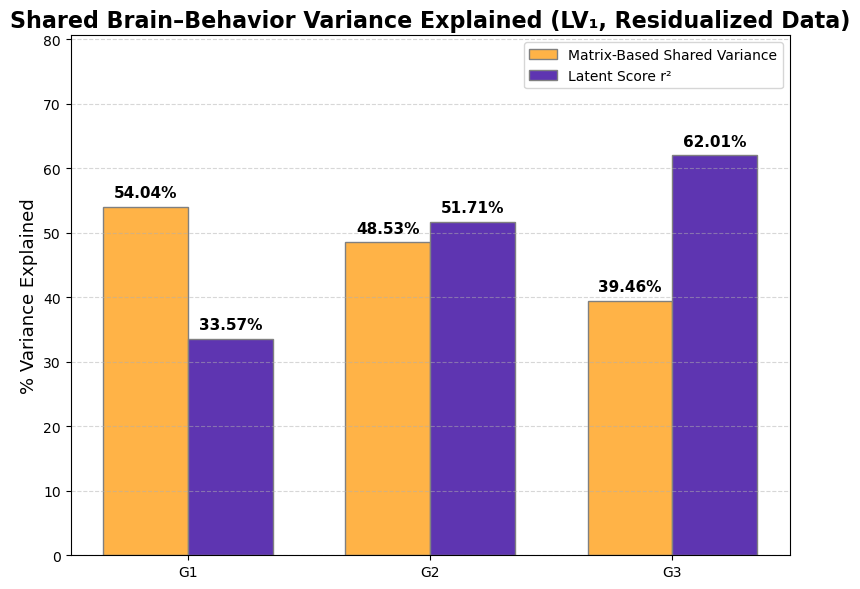

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder for figures
os.makedirs("new_figures", exist_ok=True)

var_explained_dict = {}

print("Computing variance explained for residualized (age/gender regressed) gradients-based PLS across all gradients...\n")

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results.items():

    # Residualized + standardized X and Y
    X_resid_std = res['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = res['Y_std_resid']  # behavioral data (residualized + standardized)
    n_samples = X_resid_std.shape[0]

    # Fit PLS model (LV1 only)
    pls = PLSRegression(n_components=1)
    pls.fit(X_resid_std, Y_resid_std)

    # Reconstruct predicted X and Y from LV1 scores
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained in X and Y
    var_X_expl = np.sum(X_pred**2) / np.sum(X_resid_std**2)
    var_Y_expl = np.sum(Y_pred**2) / np.sum(Y_resid_std**2)

    # Shared variance (cross-covariance matrix–based)
    C_full = (X_resid_std.T @ Y_resid_std) / (n_samples - 1)
    C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
    total_cross_energy = np.sum(C_full**2)
    explained_cross_energy = np.sum(C_pred**2)
    shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

    # Latent scores squared correlation (r² between LV1 scores)
    t = pls.x_scores_[:, 0]
    u = pls.y_scores_[:, 0]
    r2_latent = np.corrcoef(t, u)[0, 1] ** 2

    # Store in the main results dict
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var_matrix'] = shared_var_matrix
    res['r2_latent'] = r2_latent

    # Collect for combined summary
    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared_matrix%': shared_var_matrix * 100,
        'r2_latent%': r2_latent * 100
    }

    # Print per-gradient summary
    print(f"{grad_name}:")
    print(f"  LV1 explains {var_X_expl*100:.2f}% of X variance, "
          f"{var_Y_expl*100:.2f}% of Y variance, "
          f"{shared_var_matrix*100:.2f}% of total X–Y cross-covariance energy, "
          f"and t–u squared correlation = {r2_latent*100:.2f}%\n")

# -------------------------------
# Combined bar plot for all gradients
# -------------------------------
grad_names = list(var_explained_dict.keys())
matrix_vals = [v['Shared_matrix%'] for v in var_explained_dict.values()]
latent_vals = [v['r2_latent%'] for v in var_explained_dict.values()]

x = np.arange(len(grad_names))
width = 0.35  # width of bars

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, matrix_vals, width,
        label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, latent_vals, width,
        label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Add value labels
for i in range(len(grad_names)):
    plt.text(x[i] - width/2, matrix_vals[i] + 1, f"{matrix_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, latent_vals[i] + 1, f"{latent_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, grad_names)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁, Residualized Data)", fontsize=16, fontweight='bold')
plt.ylim(0, max(max(matrix_vals), max(latent_vals)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1_resid.png", dpi=300)
plt.show()


# PLS gradients parcelwise without cognition

In [11]:
"""
Partial Least Squares (PLS) pipeline for cortical gradient–behavior relationships,
excluding cognitive domain variables (only clinical/symptom measures used).

Covariates (age, gender) are regressed out from both brain and behavioral data.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

# ------------------------
# Define cortical gradients
# ------------------------
grad_files = ['./g1_aligned_cog_updated.csv', './g2_aligned_cog_updated.csv', './g3_aligned_cog_updated.csv']
grad_names = ['G1', 'G2', 'G3']

# ------------------------
# Define variable groups
# ------------------------
group_definitions = {
    'Attention_WorkingMemory': ['Digit_span_forward', 'Digit_span_backward',
                                'Digit_span_sequencing', 'Letter_number_sequencing'],
    'VerbalLearning_Memory': ['Long_free_recall', 'Short_free_recall', 'Free_recall_correct'],
    'Reasoning_ProblemSolving': ['Matrix_Reasoning'],
    'Verbal_Comprehension': ['Vocabulary']
}

# Clinical + demographic variables to include (no cognition here)
clinical_vars = ['diagnosis', 'SAPSDisorganization', 'Amotivation', 'DimEx',
                 'SAPSPositiveSymptoms', 'hamilton_21', 'YMRS']

# Covariates
covariate_cols = ['age', 'gender']

# ------------------------
# Helper functions
# ------------------------
def ensure_numeric_encoding(df, col):
    if not np.issubdtype(df[col].dtype, np.number):
        mapping = {k: i for i, k in enumerate(df[col].unique())}
        print(f"Auto-mapped '{col}': {mapping}")
        df[col] = df[col].map(mapping)
    return df

def regress_out(X, covariates):
    X_resid = np.zeros_like(X)
    for j in range(X.shape[1]):
        model = LinearRegression().fit(covariates, X[:, j])
        X_resid[:, j] = X[:, j] - model.predict(covariates)
    return X_resid

# ------------------------
# Main analysis
# ------------------------
results_nocog = {}

for grad_file, grad_name in zip(grad_files, grad_names):
    print(f"\n--- Processing {grad_name} (no cognition) ---")

    df = pd.read_csv(grad_file)
    patient_df = df[df['diagnosis'].isin([2, 3])].copy()

    for col in ['gender', 'diagnosis']:
        patient_df = ensure_numeric_encoding(patient_df, col)

    parcel_cols = [f'node_{i+1}' for i in range(400)]
    assert all(col in patient_df.columns for col in parcel_cols), f"Missing parcel columns in {grad_name}"

    X_brain = patient_df[parcel_cols].values

    # ------------------------
    # Only clinical/symptom variables in Y
    # ------------------------
    Y_behav = patient_df[clinical_vars].values
    Y_cols = clinical_vars

    # ------------------------
    # Remove subjects with missing data
    # ------------------------
    nan_rows_X = np.isnan(X_brain).any(axis=1)
    nan_rows_Y = np.isnan(Y_behav).any(axis=1)
    valid_mask = ~(nan_rows_X | nan_rows_Y)

    X_brain_valid = X_brain[valid_mask]
    Y_behav_valid = Y_behav[valid_mask]
    patient_df_valid = patient_df.loc[valid_mask].copy()

    # ------------------------
    # Regress out covariates from both X and Y
    # ------------------------
    covars = patient_df_valid[covariate_cols].values
    X_resid_brain = regress_out(X_brain_valid, covars)


    # ------------------------
    # Z-score residualized data
    # ------------------------
    X_std_resid = StandardScaler().fit_transform(X_resid_brain)
    Y_std_resid = StandardScaler().fit_transform(Y_behav_valid)

    # ------------------------
    # Fit PLS
    # ------------------------
    pls = PLSRegression(n_components=1)
    pls.fit(X_std_resid, Y_std_resid)

    X_saliences = pls.x_weights_[:, 0]
    Y_saliences = pls.y_weights_[:, 0]
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]

    behav_corrs = {}
    for i, var in enumerate(Y_cols):
        corr, _ = pearsonr(Y_std_resid[:, i], Y_scores)
        behav_corrs[var] = corr

    # Store results
    results_nocog[grad_name] = {
        'X_scores': X_scores,
        'Y_scores': Y_scores,
        'X_saliences': X_saliences,
        'Y_saliences': Y_saliences,
        'behav_corrs': behav_corrs,
        'valid_idx': valid_mask,
        'patient_df': patient_df_valid,
        'X_std_resid': X_std_resid,
        'Y_std_resid': Y_std_resid
    }

    print(f"{grad_name} behavioral correlations (clinical only):")
    for var, corr in behav_corrs.items():
        print(f"  {var:25s}: {corr:6.3f}")

print("\nAll gradients processed (no cognition). Results stored in `results_nocog` dict.")



--- Processing G1 (no cognition) ---
G1 behavioral correlations (clinical only):
  diagnosis                :  0.694
  SAPSDisorganization      : -0.536
  Amotivation              : -0.712
  DimEx                    : -0.613
  SAPSPositiveSymptoms     : -0.786
  hamilton_21              : -0.386
  YMRS                     : -0.233

--- Processing G2 (no cognition) ---
G2 behavioral correlations (clinical only):
  diagnosis                :  0.589
  SAPSDisorganization      : -0.535
  Amotivation              : -0.747
  DimEx                    : -0.589
  SAPSPositiveSymptoms     : -0.765
  hamilton_21              : -0.528
  YMRS                     : -0.312

--- Processing G3 (no cognition) ---
G3 behavioral correlations (clinical only):
  diagnosis                :  0.381
  SAPSDisorganization      : -0.750
  Amotivation              : -0.704
  DimEx                    : -0.333
  SAPSPositiveSymptoms     : -0.630
  hamilton_21              : -0.598
  YMRS                     : -0.64

## Permutation testing

In [12]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression

# -------------------------------
# Permutation testing parameters
# -------------------------------
n_permutations = 10000  # number of permutations
n_components = 1         # LV1 only
results_perm_nocog = {}        # store permutation p-values

# Loop over gradients (G1, G2, G3)
for grad_name in results_nocog.keys():
    print(f"Permutation testing for {grad_name}...")

    # Retrieve standardized + residualized X and Y
    X_resid_std = results_nocog[grad_name]['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = results_nocog[grad_name]['Y_std_resid']  # behavioral data (residualized + standardized)

    # Fit original PLS to get observed singular value
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_resid_std, Y_resid_std)

    # Observed covariance for LV1
    X_scores = pls.x_scores_[:, 0]
    Y_scores = pls.y_scores_[:, 0]
    obs_singular_value = np.cov(X_scores, Y_scores, bias=True)[0, 1]  # covariance

    # -----------------------
    # Run permutations
    # -----------------------
    perm_singular_values = np.zeros(n_permutations)
    for i in range(n_permutations):
        # Shuffle rows of X (breaks brain–behavior correspondence)
        X_perm = X_resid_std[np.random.permutation(X_resid_std.shape[0]), :]
        pls_perm = PLSRegression(n_components=n_components)
        pls_perm.fit(X_perm, Y_resid_std)

        X_scores_perm = pls_perm.x_scores_[:, 0]
        Y_scores_perm = pls_perm.y_scores_[:, 0]

        # Compute covariance for LV1
        perm_singular_values[i] = np.cov(X_scores_perm, Y_scores_perm, bias=True)[0, 1]

    # Compute p-value: proportion of permuted covariances >= observed
    p_value = np.mean(perm_singular_values >= obs_singular_value)

    # Store results
    results_perm_nocog[grad_name] = {
        'obs_singular_value': obs_singular_value,
        'perm_singular_values': perm_singular_values,
        'p_value': p_value
    }

    print(f"{grad_name} LV1 permutation p-value: {p_value:.4f}")


Permutation testing for G1...


c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
c:\Users\ferraras\AppData\Local\miniforge3\envs\gradient\lib\site-packages\sklearn\cross_decomposition\_pls.py:104: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


G1 LV1 permutation p-value: 0.1584
Permutation testing for G2...
G2 LV1 permutation p-value: 0.6612
Permutation testing for G3...
G3 LV1 permutation p-value: 0.5829


## Bootstrap resampling

Bootstrap resampling for G1...


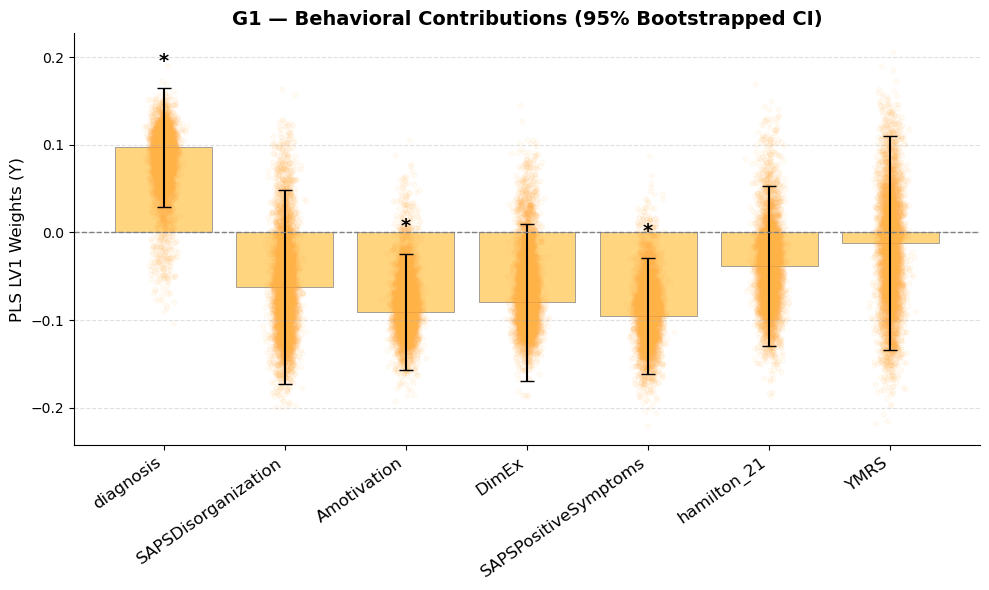

Bootstrap resampling for G2...


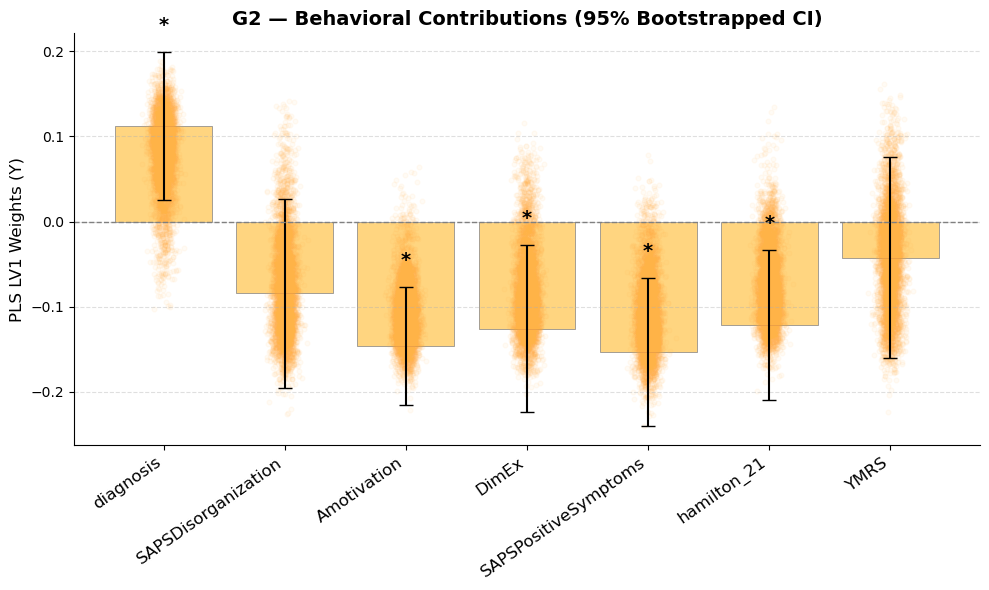

Bootstrap resampling for G3...


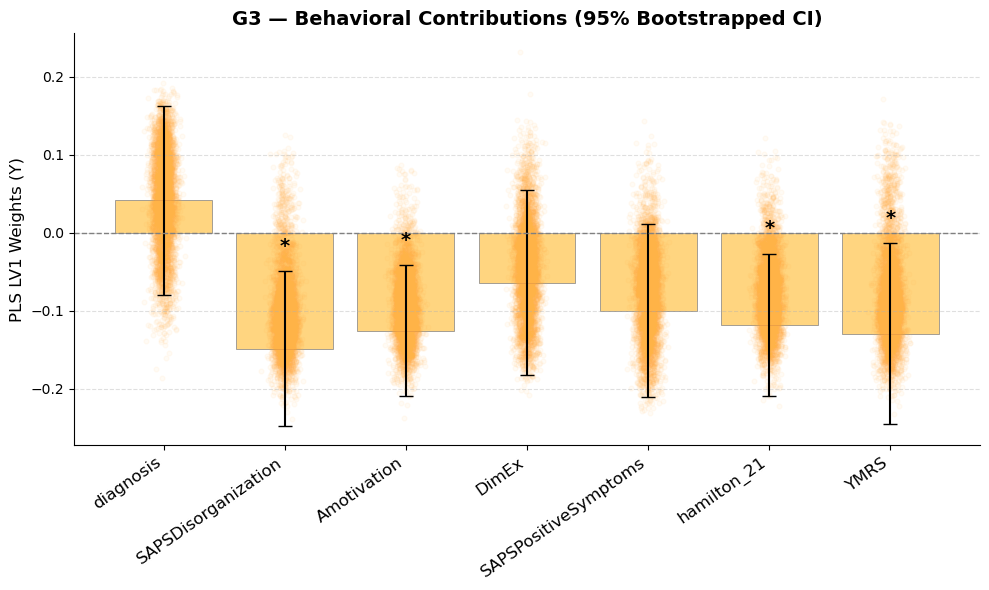

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

# -------------------------------
# Bootstrap parameters
# -------------------------------
n_bootstrap = 5000  # number of bootstrap resamples
n_components = 1     # LV1 only
results_boot_nocog = {}    # store bootstrap ratios

# Color palette for plotting
bar_color = '#FFD580'
point_color = '#FFB347'
star_color = 'black'

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results_nocog.items():
    print(f"Bootstrap resampling for {grad_name}...")

    # Residualized + standardized X and Y
    X_resid_std = res['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = res['Y_std_resid']  # behavioral data (residualized + standardized)
    n_subjects, n_voxels = X_resid_std.shape
    n_behav = Y_resid_std.shape[1]

    # Original PLS to get original weights
    pls_orig = PLSRegression(n_components=n_components)
    pls_orig.fit(X_resid_std, Y_resid_std)
    X_orig_weights = pls_orig.x_weights_[:, 0]
    Y_orig_weights = pls_orig.y_weights_[:, 0]

    # -----------------------
    # Bootstrap resampling
    # -----------------------
    X_boot_weights = np.zeros((n_bootstrap, n_voxels))
    Y_boot_weights = np.zeros((n_bootstrap, n_behav))

    for i in range(n_bootstrap):
        # Resample subjects with replacement
        Xb, Yb = resample(X_resid_std, Y_resid_std, n_samples=n_subjects, replace=True)

        pls_boot = PLSRegression(n_components=n_components)
        pls_boot.fit(Xb, Yb)
        Xb_weights = pls_boot.x_weights_[:, 0]
        Yb_weights = pls_boot.y_weights_[:, 0]

        # -----------------------
        # Sign-flipping correction
        # -----------------------
        if np.dot(Xb_weights, X_orig_weights) < 0:
            Xb_weights *= -1
            Yb_weights *= -1

        X_boot_weights[i, :] = Xb_weights
        Y_boot_weights[i, :] = Yb_weights

    # -----------------------
    # Compute bootstrap ratios
    # -----------------------
    X_bsr = X_orig_weights / X_boot_weights.std(axis=0)
    Y_bsr = Y_orig_weights / Y_boot_weights.std(axis=0)

    results_boot_nocog[grad_name] = {
        'X_bsr': X_bsr,
        'Y_bsr': Y_bsr,
        'X_boot_weights': X_boot_weights,
        'Y_boot_weights': Y_boot_weights
    }

    # -----------------------
    # Behavioral bar plot visualization
    # -----------------------
    y_mean = Y_orig_weights
    y_sd = Y_boot_weights.std(axis=0)
    lower_ci = y_mean - 1.96 * y_sd
    upper_ci = y_mean + 1.96 * y_sd

    # Determine significance
    significant = (lower_ci > 0) | (upper_ci < 0)

    Y_cols = list(res['behav_corrs'].keys())
    fig, ax = plt.subplots(figsize=(10, 6))

    # Bars with error bars
    bars = ax.bar(
        np.arange(n_behav),
        y_mean,
        width=0.8,
        yerr=[y_mean - lower_ci, upper_ci - y_mean],
        capsize=5,
        color=bar_color,
        edgecolor='gray',
        linewidth=0.5
    )

    # Overlay bootstrap points
    for j in range(n_behav):
        x = np.random.normal(j, 0.05, size=n_bootstrap)
        ax.scatter(x, Y_boot_weights[:, j], color=point_color, alpha=0.05, s=12)

    # Zero line
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Significance stars
    for j, sig in enumerate(significant):
        if sig:
            ax.text(j, upper_ci[j] + 0.02, "*", ha='center', va='bottom',
                    fontsize=14, color=star_color, fontweight='bold')

    # Labels
    ax.set_xticks(np.arange(n_behav))
    ax.set_xticklabels(Y_cols, rotation=35, ha='right', fontsize=12)
    ax.set_ylabel('PLS LV1 Weights (Y)', fontsize=12)
    ax.set_title(f'{grad_name} — Behavioral Contributions (95% Bootstrapped CI)',
                 fontsize=14, fontweight='bold')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='--', alpha=0.4)
    ax.xaxis.grid(False)

    plt.tight_layout()
    plt.show()


## Variance explained

Computing variance explained for residualized (age/gender regressed) gradients-based PLS across all gradients...

G1:
  LV1 explains 8.55% of X variance, 12.12% of Y variance, 66.73% of total X–Y cross-covariance energy, and t–u squared correlation = 35.26%

G2:
  LV1 explains 4.70% of X variance, 17.66% of Y variance, 60.52% of total X–Y cross-covariance energy, and t–u squared correlation = 50.77%

G3:
  LV1 explains 5.61% of X variance, 15.80% of Y variance, 64.33% of total X–Y cross-covariance energy, and t–u squared correlation = 45.91%



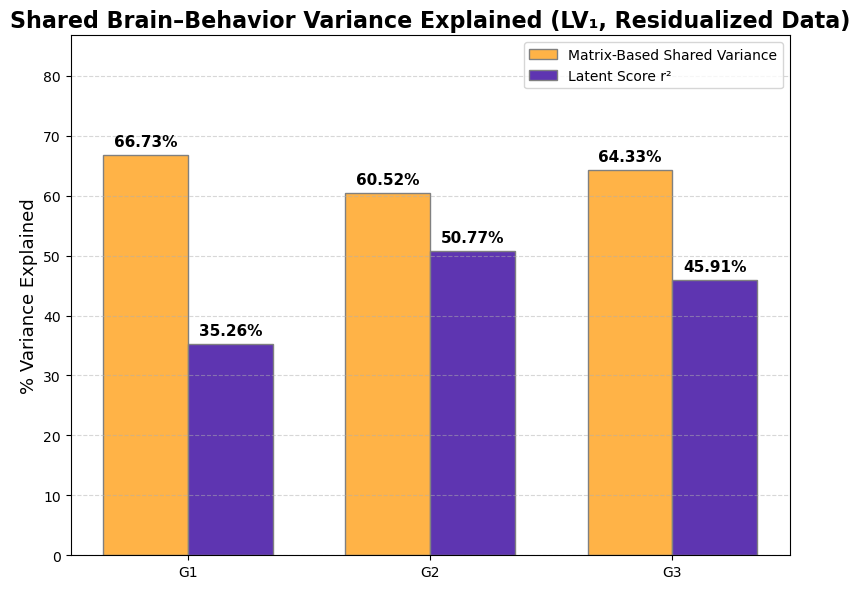

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
import os

# Create output folder for figures
os.makedirs("new_figures", exist_ok=True)

var_explained_dict = {}

print("Computing variance explained for residualized (age/gender regressed) gradients-based PLS across all gradients...\n")

# -------------------------------
# Loop over gradients
# -------------------------------
for grad_name, res in results_nocog.items():

    # Residualized + standardized X and Y
    X_resid_std = res['X_std_resid']  # brain data (residualized + standardized)
    Y_resid_std = res['Y_std_resid']  # behavioral data (residualized + standardized)
    n_samples = X_resid_std.shape[0]

    # Fit PLS model (LV1 only)
    pls = PLSRegression(n_components=1)
    pls.fit(X_resid_std, Y_resid_std)

    # Reconstruct predicted X and Y from LV1 scores
    X_pred = pls.x_scores_ @ pls.x_loadings_.T
    Y_pred = pls.x_scores_ @ pls.y_loadings_.T

    # Variance explained in X and Y
    var_X_expl = np.sum(X_pred**2) / np.sum(X_resid_std**2)
    var_Y_expl = np.sum(Y_pred**2) / np.sum(Y_resid_std**2)

    # Shared variance (cross-covariance matrix–based)
    C_full = (X_resid_std.T @ Y_resid_std) / (n_samples - 1)
    C_pred = (X_pred.T @ Y_pred) / (n_samples - 1)
    total_cross_energy = np.sum(C_full**2)
    explained_cross_energy = np.sum(C_pred**2)
    shared_var_matrix = 0.0 if total_cross_energy == 0 else explained_cross_energy / total_cross_energy

    # Latent scores squared correlation (r² between LV1 scores)
    t = pls.x_scores_[:, 0]
    u = pls.y_scores_[:, 0]
    r2_latent = np.corrcoef(t, u)[0, 1] ** 2

    # Store in the main results dict
    res['var_X_expl'] = var_X_expl
    res['var_Y_expl'] = var_Y_expl
    res['shared_var_matrix'] = shared_var_matrix
    res['r2_latent'] = r2_latent

    # Collect for combined summary
    var_explained_dict[grad_name] = {
        'X_var%': var_X_expl * 100,
        'Y_var%': var_Y_expl * 100,
        'Shared_matrix%': shared_var_matrix * 100,
        'r2_latent%': r2_latent * 100
    }

    # Print per-gradient summary
    print(f"{grad_name}:")
    print(f"  LV1 explains {var_X_expl*100:.2f}% of X variance, "
          f"{var_Y_expl*100:.2f}% of Y variance, "
          f"{shared_var_matrix*100:.2f}% of total X–Y cross-covariance energy, "
          f"and t–u squared correlation = {r2_latent*100:.2f}%\n")

# -------------------------------
# Combined bar plot for all gradients
# -------------------------------
grad_names = list(var_explained_dict.keys())
matrix_vals = [v['Shared_matrix%'] for v in var_explained_dict.values()]
latent_vals = [v['r2_latent%'] for v in var_explained_dict.values()]

x = np.arange(len(grad_names))
width = 0.35  # width of bars

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, matrix_vals, width,
        label='Matrix-Based Shared Variance',
        color='#FFB347', edgecolor='gray')
plt.bar(x + width/2, latent_vals, width,
        label='Latent Score r²',
        color='#5E35B1', edgecolor='gray')

# Add value labels
for i in range(len(grad_names)):
    plt.text(x[i] - width/2, matrix_vals[i] + 1, f"{matrix_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.text(x[i] + width/2, latent_vals[i] + 1, f"{latent_vals[i]:.2f}%",
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xticks(x, grad_names)
plt.ylabel("% Variance Explained", fontsize=13)
plt.title("Shared Brain–Behavior Variance Explained (LV₁, Residualized Data)", fontsize=16, fontweight='bold')
plt.ylim(0, max(max(matrix_vals), max(latent_vals)) * 1.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("new_figures/shared_variance_combined_LV1_resid.png", dpi=300)
plt.show()
